# Workflow of MetaRF - Tutorial

> *This ipynb introduces the whole work flow of MetaRF. The code includes four modules, Data preprocessing, Model training, Model fine-tuning and testing, Baseline comparision. For each module, there exists some submodules, which are listed below. We provide introduction under each submodule (at next section) to help users understand the workflow and run the code.*
### Data preprocessing
*   Random forest
*   Dimension reduction

### Model training
*   Installation
*   Model definition
*   Training implementation
*   Training model
*   Validation, model selection and model saving

### Model fine-tuning and testing
*   Loading model
*   Fine-tuning and printing experiment results

### Baseline Comparision
*   Random forest
*   Neural network
*   Support Vector Machine
*   Linear model
*   RXNFP
*   GemNet
*   DRFP


# Code

### Data preprocessing

#### Random forest

> *This step performs random forest. We take it out as a seperate module to make the code structure more clearly.*

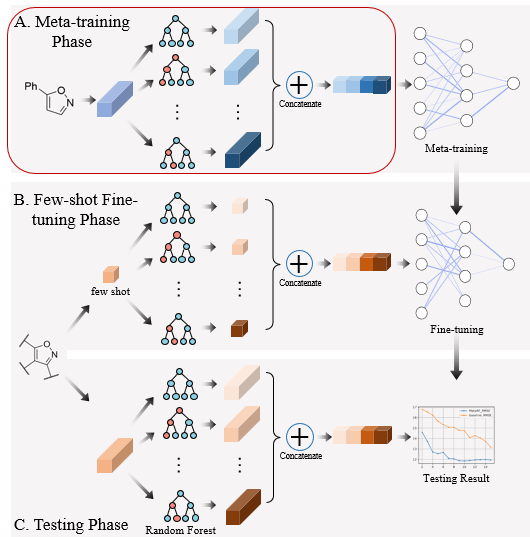

In [ ]:
import os
import csv
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

# Parameters (can be changed according to experiment setting)

BASE_DIR = os.getcwd() # The current working directory
input_path = os.path.join(BASE_DIR, 'data/Original_Data_Buchwald_Hartwig_HTE.csv') # Relative path
output_path = os.path.join(BASE_DIR, 'data/Data_After_Preprocessing_Buchwald_Hartwig_HTE.csv')

data = pd.read_csv(input_path) 
reagent = 'additive_number' 

list_train = [1,2,3,4]
list_test = [5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

dft_num = 120 # Number of the original reaction encoding

train = data[data[reagent].isin(list_train)].sample(frac=1)
test = data[data[reagent].isin(list_test)]
  
X_test = test.iloc[:,0:dft_num]
X_train = train.iloc[:,0:dft_num]
y_test = test.iloc[:,dft_num:dft_num+1].values
y_train = train.iloc[:,dft_num:dft_num+1].values 

regressor = RandomForestRegressor(n_estimators=200,max_features=61)
regressor.fit(X_train, y_train) 

y_pred = regressor.predict(X_test)  

per_tree_pred = np.array([tree.predict(data.iloc[:,0:dft_num].values) for tree in regressor.estimators_])
per_tree_pred_df = pd.DataFrame(per_tree_pred).T # the prediction results of random forest

per_tree_pred_df[reagent] = data[reagent]
per_tree_pred_df['yield'] = data['yield_dft']

data_all = per_tree_pred_df
feature_num = per_tree_pred_df.shape[1] - 2

#### Dimension reduction
> *This step applies TSNE to reduce the dimension of reaction data.*

In [ ]:
data_all = pd.concat([data.iloc[:,0:dft_num],data_all],axis=1) # optional, whether to use original feature
feature_num = feature_num + dft_num
data_all_copy = data_all.copy(deep=True)
feature = data_all_copy.iloc[:,0:feature_num]
feature = feature.values

X = feature
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  

tsne = pd.DataFrame(X_norm)
tsne.columns = ['tsne_1','tsne_2']

data_all_copy = pd.concat([data_all_copy, tsne], axis=1)
#data_all_copy.to_csv(os.path.join(BASE_DIR, output_path),index=False)

### Model training

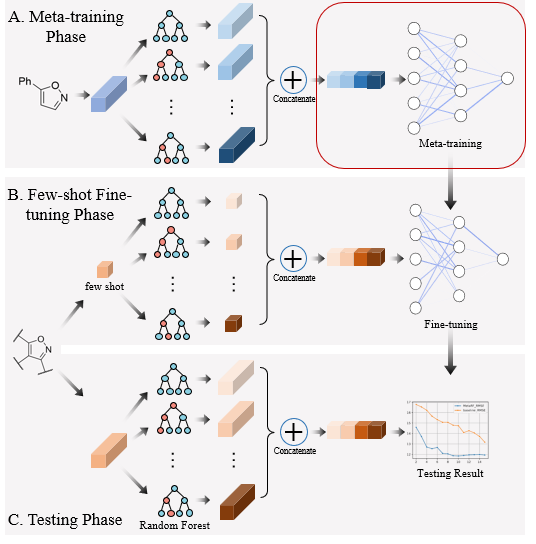

#### Installation
> *This step installs the necessary pachages.*

In [ ]:
!pip install kennard-stone

In [ ]:
!pip install -q tensorflow-gpu==2.9.0

#### Model definition
> *This step defines the model structure.*

In [ ]:
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as keras_backend
from sklearn import metrics
from pandas.core.frame import DataFrame
import sys
import time
import numpy as np
import kennard_stone as ks
import random
from tqdm import tqdm

BASE_DIR = os.getcwd() # The current working directory
input_path = os.path.join(BASE_DIR, 'data/Data_After_Preprocessing_Buchwald_Hartwig_HTE.csv') # Relative path
output_path = os.path.join(BASE_DIR, 'model/model_trained.h5') 

data_all_copy = pd.read_csv(input_path) # Read the csv file with relative path

list_train = [1,2,3,4]
list_val = [5]
list_test = [6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

train_all = data_all_copy[data_all_copy[reagent].isin(list_train)].sample(frac=1)
test_all = data_all_copy[data_all_copy[reagent].isin(list_test)]

class Model(keras.Model):
    def __init__(self):
        super().__init__()
        self.hidden1 = keras.layers.Dense(40, input_shape=(feature_num,))
        self.hidden2 = keras.layers.Dense(40)
        self.out = keras.layers.Dense(1)
        
    def forward(self, x):
        x = keras.activations.relu(self.hidden1(x))
        x = keras.activations.relu(self.hidden2(x))
        x = self.out(x)
        return x

    def call(self, x):
        x = keras.activations.relu(self.hidden1(x))
        x = keras.activations.relu(self.hidden2(x))
        x = self.out(x)
        return x

#### Training implementation
> *This step defines the functions used in the training process.*

In [ ]:
def loss_function(pred_y, y):
  return keras_backend.mean(keras.losses.mean_squared_error(y, pred_y))

def np_to_tensor(list_of_numpy_objs):
    return (tf.convert_to_tensor(obj) for obj in list_of_numpy_objs)
    

def compute_loss(model, x, y, loss_fn=loss_function):
    logits = model.forward(x)
    mse = loss_fn(y, logits)
    return mse, logits


def compute_gradients(model, x, y, loss_fn=loss_function):
    with tf.GradientTape() as tape:
        loss, _ = compute_loss(model, x, y, loss_fn)
    return tape.gradient(loss, model.trainable_variables), loss


def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))

    
def train_batch(x, y, model, optimizer):
    tensor_x, tensor_y = np_to_tensor((x, y))
    gradients, loss = compute_gradients(model, tensor_x, tensor_y)
    apply_gradients(optimizer, gradients, model.trainable_variables)
    return loss

def generate_dataset(K, train_size=60, test_size=10):

    def _generate_dataset_train(size):
        return [YieldGenerator(K=K,list_used=list_train,data=data_all) for _ in range(size)]

    return _generate_dataset_train(train_size) 

class YieldGenerator():

    def __init__(self, K=10, list_used = list_train, data = data_all):
        self.K = K
        self.data = data_all
        self.list_used = list_used
    

    def batch(self, x = None, force_new=False):
        number = random.choice(list_train)
        data_used = train_all[train_all[reagent] == number]
        data_used = data_used.sample(self.K)
        x = data_used.iloc[:,0:feature_num].values
        y = data_used[['yield']].values
        return x, y

#### Training model
> *This step defines the direct training function.*

In [ ]:
def train_maml(model, epochs, dataset, lr_inner=0.00001, batch_size=1, log_steps=1000):

    optimizer = keras.optimizers.Adam()
    
    # Step 2: instead of checking for convergence, we train for a number
    # of epochs
    for _ in range(epochs):
        total_loss = 0
        losses = []
        losses_test = []
        start = time.time()
        # Step 3 and 4
        for i, t in enumerate(random.sample(dataset, len(dataset))):
            x, y = np_to_tensor(t.batch())
            model.forward(x)  # run forward pass to initialize weights
            with tf.GradientTape() as test_tape:
                # test_tape.watch(model.trainable_variables)
                # Step 5
                with tf.GradientTape() as train_tape:
                    train_loss, _ = compute_loss(model, x, y)
                # Step 6
                gradients = train_tape.gradient(train_loss, model.trainable_variables)
                k = 0
                model_copy = copy_model(model, x)
                for j in range(len(model_copy.layers)):
                    model_copy.layers[j].kernel = tf.subtract(model.layers[j].kernel,
                                tf.multiply(lr_inner, gradients[k]))
                    model_copy.layers[j].bias = tf.subtract(model.layers[j].bias,
                                tf.multiply(lr_inner, gradients[k+1]))
                    k += 2
                # Step 8
                test_loss, logits = compute_loss(model_copy, x, y)

            # Step 8
            gradients = test_tape.gradient(test_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            # Logs
            total_loss += test_loss
            loss = total_loss / (i+1.0)
            losses.append(loss)
            

def copy_model(model, x):

    copied_model = Model()
    copied_model.forward(tf.convert_to_tensor(x))
    
    copied_model.set_weights(model.get_weights())
    return copied_model

#### Validation, model selection and model saving
> *This step defines the functions used to validate the model. It also includes the code of model selection and model saving.*

In [ ]:
def eval_all_ks_tune_num_val(model,tune_num=10):

  y_test_all = []
  y_pred_all = []

  for i in range(len(list_val)):
    y_test,y_pred,df1,df2,df_plot = eval_ks_tune_num(model,number = list_val[i],tune_num=tune_num)

    y_test_all += y_test
    y_pred_all += y_pred

  r2 = metrics.r2_score(y_test_all, y_pred_all)
  rmse = np.sqrt(metrics.mean_squared_error(y_test_all, y_pred_all))

  return r2,rmse

def eval_ks_tune_num(model, data = data_all, num_steps=(0, 1, 2,3,4,5,6,7,8,9,10), lr=0.00001, number = 16,tune_num=10):

    df1 = pd.DataFrame()
    df2 = pd.DataFrame()
    df_plot = pd.DataFrame()
    tmp = data_all_copy[data_all_copy[reagent] == number]

    data_used = tmp.reset_index().drop(columns=['index'])
    data_used_plot = tmp.reset_index()

    X = data_used.iloc[:,feature_num+2:feature_num+4]
    y = data_used.iloc[:,feature_num+1:feature_num+2]

    all_num = len(data_used)

    X_train_, X_test_, y_train_, y_test_ = ks.train_test_split(X, y, test_size = 1 - tune_num/all_num)
    top_k_idx = X_train_.index.tolist()

    data_sampled = data_used.loc[top_k_idx]
    data_sampled_plot = data_used_plot.loc[top_k_idx].set_index(["index"])

    # batch used for training
    data_minus = data_used.append(data_sampled).drop_duplicates(keep=False)

    x_test = data_minus.iloc[:,0:feature_num].values
    y_test = data_minus[['yield']].values.flatten().tolist()
    
    x = data_sampled.iloc[:,0:feature_num].values
    y = data_sampled[['yield']].values

    
    # copy model so we can use the same model multiple times
    copied_model = copy_model(model, x)
    
    # use SGD for this part of training as described in the paper
    optimizer = keras.optimizers.SGD(learning_rate=lr)
    
    # run training and log fit results
    fit_res,best_res = evaluation(copied_model, optimizer, x, y, x_test, y_test, num_steps)
    
    #y_pred = np.clip(best_res[0][1].numpy().flatten(), 0, 100)
    #y_pred = best_res[0][1].numpy().flatten()
    y_pred = fit_res[1][1].numpy().flatten().tolist()

    
    df1 = data_sampled
    df2 = data_minus
    df_plot = data_sampled_plot

    return y_test,y_pred,df1,df2,df_plot

def evaluation(model, optimizer, x, y, x_test, y_test, num_steps=(0, 1, 2,3,4,5,6,7,8,9,10)):

    fit_res = []
    best_res = []
    min_loss = 1000000000
    
    tensor_x_test, tensor_y_test = np_to_tensor((x_test, y_test))
    
    # If 0 in fits we log the loss before any training
    if 0 in num_steps:
        loss, logits = compute_loss(model, tensor_x_test, tensor_y_test)
        fit_res.append((0, logits, loss))
        
    for step in range(1, np.max(num_steps) + 1):
        train_batch(x, y, model, optimizer)
        loss, logits = compute_loss(model, tensor_x_test, tensor_y_test)
        if step in num_steps:
            fit_res.append(
                (
                    step, 
                    logits,
                    loss
                )
            )

        if loss < min_loss:
          best_res = []
          best_res.append(
                (
                    step, 
                    logits,
                    loss
                )
            )
          min_loss = loss
    
    return fit_res,best_res

val_times = 3
feature_num = 320
result = pd.DataFrame()
train_ds = generate_dataset(K=20,train_size=80)

# model selection with validation set
model_list = []
for i in range(val_times): 
  maml = Model()  
  train_maml(maml, 20, train_ds, log_steps=10)
  model_list.append(maml)
  r2,rmse = eval_all_ks_tune_num_val(maml,tune_num = 5)

  c={"r2_val" : [r2]}
  frame = pd.DataFrame(c)
  frame['val_times'] = i
  result = result.append(frame)

tmp = result[result['r2_val']==result['r2_val'].max()]
#model_list[tmp.at[0,'val_times']].save_weights(output_path) # Save the model

### Model fine-tuning and testing

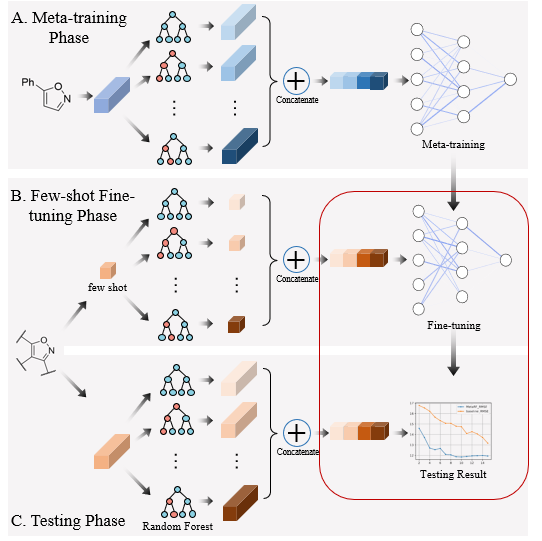

#### Loading model
> *This step loads the trained model.*

In [ ]:
model_path = os.path.join(BASE_DIR, 'model/model_trained.h5')

maml_saved = Model()
maml_saved.build(input_shape = (320,320))
maml_saved.load_weights(model_path)

#### Fine-tuning and printing experiment results
> *This step performs model fine-tuning and prints out experiment results.*

In [ ]:
def eval_all_ks_tune_num(model,tune_num=10):

  y_test_all = []
  y_pred_all = []

  for i in range(len(list_test)):
    y_test,y_pred,df1,df2,df_plot = eval_ks_tune_num(model,number = list_test[i],tune_num=tune_num)

    y_test_all += y_test
    y_pred_all += y_pred

  r2 = metrics.r2_score(y_test_all, y_pred_all)
  rmse = np.sqrt(metrics.mean_squared_error(y_test_all, y_pred_all))
  print("r2:",r2)
  print("rmse:",rmse)

In [ ]:
eval_all_ks_tune_num(maml_saved,tune_num=5)   

### Baseline Comparsion

In [ ]:
import csv
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

BASE_DIR = os.getcwd() # The current working directory
input_path = os.path.join(BASE_DIR, 'data/Data_After_Preprocessing_Buchwald_Hartwig_HTE.csv') # Relative path

data = pd.read_csv(input_path) # Read the csv file with relative path
reagent = 'additive_number'

list_train = [1,2,3,4]
list_val = [5]
list_test = [6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

dft_num = 120 # Number of the original reaction encoding

def eval_all_baseline(sample_num=5): 
  y_test_all = []
  y_pred_all = []

  for i in tqdm(range(len(list_test))):
    y_test,y_pred = eval_baseline(number = list_test[i],sample_num=sample_num)

    y_test_all += y_test
    y_pred_all += y_pred

  rmse = np.sqrt(metrics.mean_squared_error(y_test_all, y_pred_all))
  r2 = metrics.r2_score(y_test_all, y_pred_all)
  mae = mean_absolute_error(y_test_all, y_pred_all)
  print(rmse)
  print(r2)
  print(mae)
  return rmse,r2,mae

def eval_baseline(number = 16,sample_num=5): 

    tmp1 = data[data[reagent].isin(list_train)]
    X_train = tmp1.iloc[:,0:dft_num]
    y_train = tmp1[['yield']]
    test = pd.DataFrame()

    tmp = data[data[reagent] == number]
    df1 = tmp.sample(sample_num)
    df2 = pd.concat([tmp, df1]).drop_duplicates(keep=False)

    X_train = pd.concat([X_train, df1.iloc[:,0:dft_num]])
    y_train = pd.concat([y_train, df1[['yield']]])
    test = pd.concat([test, df2])

    X_train = X_train.values
    y_train = y_train.values
    X_test = test.iloc[:,0:dft_num].values
    y_test = test[['yield']].values.flatten().tolist()

    regressor = regressor_model
    regressor.fit(X_train, y_train.ravel())
    y_pred = regressor.predict(X_test).tolist()

    return y_test,y_pred

#### Random forest

In [ ]:
regressor_model = RandomForestRegressor()
eval_all_baseline(sample_num=5)

#### Neural network

In [ ]:
regressor_model = MLPRegressor()
eval_all_baseline(sample_num=5)

#### SVM

In [ ]:
regressor_model = SVR(kernel='linear')
eval_all_baseline(sample_num=5)

#### Linear model

In [ ]:
regressor_model = LinearRegression()
eval_all_baseline(sample_num=5)

#### RXNFP
For more details about RXNFP, please refer to https://github.com/rxn4chemistry/rxn_yields

In [ ]:
import pkg_resources
import torch
from rxnfp.models import SmilesClassificationModel
from rdkit import Chem
from rdkit.Chem import rdChemReactions
import pandas as pd

def generate_buchwald_hartwig_rxns(df):
    """
    Converts the entries in the excel files from Sandfort et al. to reaction SMILES.
    """
    df = df.copy()
    fwd_template = "[F,Cl,Br,I]-[c;H0;D3;+0:1](:[c,n:2]):[c,n:3].[NH2;D1;+0:4]-[c:5]>>[c,n:2]:[c;H0;D3;+0:1](:[c,n:3])-[NH;D2;+0:4]-[c:5]"
    methylaniline = "Cc1ccc(N)cc1"
    pd_catalyst = "O=S(=O)(O[Pd]1~[NH2]C2C=CC=CC=2C2C=CC=CC1=2)C(F)(F)F"
    methylaniline_mol = Chem.MolFromSmiles(methylaniline)
    rxn = rdChemReactions.ReactionFromSmarts(fwd_template)
    products = []

    for i, row in df.iterrows():
        reacts = (Chem.MolFromSmiles(row["aryl_halide_smiles"]), methylaniline_mol)
        rxn_products = rxn.RunReactants(reacts)

        rxn_products_smiles = set([Chem.MolToSmiles(mol[0]) for mol in rxn_products])
        assert len(rxn_products_smiles) == 1
        products.append(list(rxn_products_smiles)[0])

    df["product"] = products
    rxns = []

    for i, row in df.iterrows():
        reactants = Chem.MolToSmiles(
            Chem.MolFromSmiles(
                f"{row['aryl_halide_smiles']}.{methylaniline}.{pd_catalyst}.{row['ligand_smiles']}.{row['base_smiles']}.{row['additive_smiles']}"
            )
        )
        rxns.append(f"{reactants.replace('N~', '[NH2]')}>>{row['product']}")

    return rxns

In [ ]:
data['rxn'] = generate_buchwald_hartwig_rxns(data)
train_df = data[data[reagent].isin(list_train)]
test_df = pd.DataFrame()

for i in range(len(list_test)):
  tmp = data[data[reagent] == list_test[i]]
  df1 = tmp.sample(5)
  df2 = tmp.append(df1).drop_duplicates(keep=False)

  train_df = train_df.append(df1)
  test_df = test_df.append(df2)

train_df = train_df[['rxn','yield_smiles']]
test_df = test_df[['rxn','yield_smiles']]
train_df.columns = ['text', 'labels']
test_df.columns = ['text', 'labels']

mean = train_df.labels.mean()
std = train_df.labels.std()
train_df['labels'] = (train_df['labels'] - mean) / std
test_df['labels'] = (test_df['labels'] - mean) / std

In [ ]:
model_args = {
     'num_train_epochs': 15, 'overwrite_output_dir': True,
    'learning_rate': 0.00009659, 'gradient_accumulation_steps': 1,
    'regression': True, "num_labels":1, "fp16": False,
    "evaluate_during_training": False, 'manual_seed': 42,
    "max_seq_length": 300, "train_batch_size": 16,"warmup_ratio": 0.00,
    "config" : { 'hidden_dropout_prob': 0.7987 } 
}

model_path =  pkg_resources.resource_filename(
                "rxnfp",
                f"models/transformers/bert_pretrained" # change pretrained to ft to start from the other base model
)

yield_bert = SmilesClassificationModel("bert", model_path, num_labels=1, 
                                       args=model_args, use_cuda=torch.cuda.is_available())

yield_bert.train_model(train_df, output_dir=f"outputs_buchwald_hartwig_test_project", eval_df=test_df)

In [ ]:
model_path = os.path.join(BASE_DIR, 'outputs_buchwald_hartwig_test_project/checkpoint-765-epoch-15') # Relative path

trained_yield_bert = SmilesClassificationModel('bert', model_path,
                                  num_labels=1, args={
                                      "regression": True
                                  }, use_cuda=torch.cuda.is_available())

yield_predicted = trained_yield_bert.predict(test_df.text.values.tolist())[0]
yield_predicted = yield_predicted * std + mean

yield_true = test_df.labels.values
yield_true = yield_true * std + mean

rmse = np.sqrt(metrics.mean_squared_error(yield_predicted, yield_true))
mae = mean_absolute_error(yield_predicted, yield_true)

#### GemNet
##### Since the implementation code is too long, please refer to another link:https://drive.google.com/file/d/1K532m1gGivUBmLu6RUZ-GAQxPk6mbqKS/view?usp=sharing

#### DRFP
##### For more details about DRFP, please refer to https://github.com/reymond-group/drfp

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdChemReactions
from drfp import DrfpEncoder
from xgboost import XGBRegressor

def eval_baseline_dfrp(number = 16,sample_num=5): 

    train_df = data[data[reagent].isin(list_train)]
    test_df = pd.DataFrame()

    tmp = data[data[reagent] == number]
    df1 = tmp.sample(sample_num)
    df2 = tmp.append(df1).drop_duplicates(keep=False)

    train_df = train_df.append(df1)
    test_df = test_df.append(df2)

    train_df = train_df[['rxn','yield_smiles']]
    test_df = test_df[['rxn','yield_smiles']]
    train_df.columns = ['text', 'labels']
    test_df.columns = ['text', 'labels']

    X_train, mapping = DrfpEncoder.encode(
            train_df.text.to_numpy(),
            n_folded_length=2048,
            radius=3,
            rings=True,
            mapping=True,
        )
    X_train = np.asarray(
            X_train,
            dtype=np.float32,
        )
    y_train = train_df.labels.to_numpy()

    X_test, _ = DrfpEncoder.encode(
            test_df.text.to_numpy(),
            n_folded_length=2048,
            radius=3,
            rings=True,
            mapping=True,
        )
    X_test = np.asarray(
            X_test,
            dtype=np.float32,
        )
    y_test = test_df.labels.to_numpy()

    valid_indices = np.random.choice(
        np.arange(len(X_train)), int(0.1 * len(X_train)), replace=False
    )

    X_valid = X_train[valid_indices]
    y_valid = y_train[valid_indices]
    train_indices = list(set(range(len(X_train))) - set(valid_indices))

    X_train = X_train[train_indices]
    y_train = y_train[train_indices]

    model = XGBRegressor()
    model.fit(
                X_train,
                y_train,
                eval_set=[(X_valid, y_valid)],
                early_stopping_rounds=20,
                verbose=False,
            )
    y_pred = model.predict(X_test, ntree_limit=model.best_ntree_limit)
    y_pred[y_pred < 0.0] = 0.0

    return y_test.tolist(),y_pred.tolist()

def eval_all_baseline_DRFP(sample_num=5): 
  y_test_all = []
  y_pred_all = []

  for i in tqdm(range(len(list_test))):
    y_test,y_pred = eval_baseline_dfrp(number = list_test[i],sample_num=sample_num)

    y_test_all += y_test
    y_pred_all += y_pred

  rmse = np.sqrt(metrics.mean_squared_error(y_test_all, y_pred_all))
  r2 = metrics.r2_score(y_test_all, y_pred_all)
  mae = mean_absolute_error(y_test_all, y_pred_all)
  print(rmse)
  print(r2)
  print(mae)
  return rmse,r2,mae

In [ ]:
eval_all_baseline_drfp()